# Unsupervised learning: applying deep embedding clustering for object identification

## Authors: 
Djordje Savic (Postdoc)  
Isidora Jankov (PhD student)

## Assistant:  
Iva Čvorović-Hajdinjak (PhD student)

## Code specification

**Reproducibility:**  
This is an end-to-end example reproducible in the SciServer Essentials 2.0 with the preinstalled Python environment "py38" with tensorflow installed.
The user should navigate to Stripe82 Object Table 's82ObjectTable.parquet'. Some of the pretrained models are stored in the directory "./NNcheckpoints/". Models in this example are labeled with "DEC_acc*.hp, where * denotes accuracy. The model "./NNcheckpoints/DEC_acc0.97091.hp" is the best accuracy model tested on 50:50 train/test split.
This model was initially trained on a server with 80 cores and 512 GB RAM memory

**Should the notebook be run on the blinded dataset?**  
We would like this model to be evaluated on the blinded dataset. Any of the models with 96-97% accuracy e.g. "DEC_acc0.97091.hp" could be run on the blinded dataset.

**Working with already trained models**  
There are a few trained models that could be loaded from the "./NNcheckpoints/" directory. The code needs to be executed until (and including) the cell with the autoencoder definition (just before the autoencoder training cell). After that, the training part can be skipped by executing the bottom code cell that loads the trained model. Afterwards, executing the second to bottom cell will display the output of model predictions performed on the test set.

**Code version:** in development phase

**Sample:** Tests performed on a subsample with size of ~64,000 objects (50% of the AGN DC Stripe82 Object Table when NaN values are excluded).


## Contents:

1. Introduction and motivation
2. Data reading and pre-processing
3. Model definitions and training part
4. Loading the pretrained model
5. Conclusion

## 1. Introduction  and motivation
The main goal of this work aims at building a data driven model for unsupervised form of classification problem and AGN selection with the future LSST sky survey. We used a deep embedding clustering (DEC) approach ([Xie et al. 2015](https://arxiv.org/abs/1511.06335)). In this example, the original model has been adjusted and the code has been adapted for treating the problem on tabular data. A more complex model with object images and Improved Deep Embedded Clustering ([Guo et al. 2017](https://www.ijcai.org/proceedings/2017/0243.pdf)) is currently in consideration by SER-SAG team..

## 2. Data reading and pre-processing

In [1]:
## commonly used modules
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer, InputSpec
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
#import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
import yaml
import seaborn as sns
import importlib

from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', 1000)

In [2]:
#"/home/idies/workspace/Storage/djsavic/persistent/LSST_training/Script_NBs/Kodovi" # scripts are located in this directory

## Data challenge root data dir
data_dir = "/home/idies/workspace/Temporary/ywx649999311/LSST_AGN/Class_Training/DC/"
#data_dir = "./Datasets/"

# Examine the data directory
display(data_dir)
#!ls "/home/idies/workspace/Temporary/ywx649999311/LSST_AGN/Class_Training/DC/"

'/home/idies/workspace/Temporary/ywx649999311/LSST_AGN/Class_Training/DC/'

### Clustering layer
We implemented the same clustering layer definition in Keras as [Guo](https://github.com/XifengGuo/DEC-keras/blob/master/DEC.py).

In [3]:
"""
Keras implementation for Deep Embedded Clustering (DEC) algorithm:
        Junyuan Xie, Ross Girshick, and Ali Farhadi. Unsupervised deep embedding for clustering analysis. ICML 2016.
Author:
    Xifeng Guo.
    2017.1.30 https://github.com/XifengGuo/DEC-keras/blob/master/DEC.py
"""

class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        #assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.        
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        #assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

# normalized mutual information and adjusted Rand score
nmi_f = normalized_mutual_info_score
ari_f = adjusted_rand_score

### Data selection
The object table follows the current version of the LSST Data Products document (LSE-163) as much as possible with measurements of included objects in the following main catalogries:
- __Astromety__ -> ra, dec, proper motion and parallax
- __Photometry__ -> point and extended source photometry, in both AB magnitdues and fluxes (nJy)
- __Color__ -> Computed using the fluxes
- __Morphology__ -> 1 for extended and 0 for point-like
- __Light Curve Features__ -> Extrated on the SDSS light curves if matched
- __Redshift__ -> Both spectroscopic and photometric, wherever available

In [4]:
# reading S82 object table
object_df = pd.read_parquet(os.path.join(data_dir, 's82ObjectTable.parquet'))
#object_df = pd.read_csv(os.path.join(data_dir, 's82ObjectTableDF.csv')) #
display(object_df.describe())
display(object_df.shape)
# Number of objects in each class + unlabeled
display(object_df['class'].value_counts())
display("Number of unlabeled objects: {}".format(object_df['class'].isna().sum()))

,ra,dec,psPm_ra,psPm_dec,psParallax,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,psFlux_y,psFluxErr_u,psFluxErr_g,psFluxErr_r,psFluxErr_i,psFluxErr_z,psFluxErr_y,bdFlux_u,bdFlux_g,bdFlux_r,bdFlux_i,bdFlux_z,bdFlux_y,bdFluxErr_u,bdFluxErr_g,bdFluxErr_r,bdFluxErr_i,bdFluxErr_z,bdFluxErr_y,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,psMagErr_u,psMagErr_g,psMagErr_r,psMagErr_i,psMagErr_z,psMagErr_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,bdMagErr_u,bdMagErr_g,bdMagErr_r,bdMagErr_i,bdMagErr_z,bdMagErr_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,extendedness_y,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,stdColorErr_0,stdColorErr_1,stdColorErr_2,stdColorErr_3,stdColorErr_4,photoZ_pest,z,flags_u,flags_g,flags_r,flags_i,flags_z,flags_y,lcPeriodic[0]_g,lcPeriodic[0]_r,lcPeriodic[0]_i,lcPeriodic[1]_g,lcPeriodic[1]_r,lcPeriodic[1]_i,lcPeriodic[2]_g,lcPeriodic[2]_r,lcPeriodic[2]_i,lcPeriodic[3]_g,lcPeriodic[3]_r,lcPeriodic[3]_i,lcPeriodic[4]_u,lcPeriodic[4]_g,lcPeriodic[4]_r,lcPeriodic[4]_i,lcPeriodic[4]_z,lcPeriodic[5]_u,lcPeriodic[5]_g,lcPeriodic[5]_r,lcPeriodic[5]_i,lcPeriodic[5]_z,lcPeriodic[6]_u,lcPeriodic[6]_g,lcPeriodic[6]_r,lcPeriodic[6]_i,lcPeriodic[6]_z,lcPeriodic[7]_u,lcPeriodic[7]_g,lcPeriodic[7]_r,lcPeriodic[7]_i,lcPeriodic[7]_z,lcPeriodic[8]_u,lcPeriodic[8]_g,lcPeriodic[8]_r,lcPeriodic[8]_i,lcPeriodic[8]_z,lcPeriodic[9]_u,lcPeriodic[9]_g,lcPeriodic[9]_r,lcPeriodic[9]_i,lcPeriodic[9]_z,lcPeriodic[10]_u,lcPeriodic[10]_g,lcPeriodic[10]_r,lcPeriodic[10]_i,lcPeriodic[10]_z,lcPeriodic[11]_u,lcPeriodic[11]_g,lcPeriodic[11]_r,lcPeriodic[11]_i,lcPeriodic[11]_z,lcPeriodic[12]_u,lcPeriodic[12]_g,lcPeriodic[12]_r,lcPeriodic[12]_i,lcPeriodic[12]_z,lcPeriodic[13]_u,lcPeriodic[13]_g,lcPeriodic[13]_r,lcPeriodic[13]_i,lcPeriodic[13]_z,lcPeriodic[14]_u,lcPeriodic[14]_g,lcPeriodic[14]_r,lcPeriodic[14]_i,lcPeriodic[14]_z,lcPeriodic[15]_u,lcPeriodic[15]_g,lcPeriodic[15]_r,lcPeriodic[15]_i,lcPeriodic[15]_z,lcPeriodic[16]_u,lcPeriodic[16]_g,lcPeriodic[16]_r,lcPeriodic[16]_i,lcPeriodic[16]_z,lcPeriodic[17]_u,lcPeriodic[17]_g,lcPeriodic[17]_r,lcPeriodic[17]_i,lcPeriodic[17]_z,lcPeriodic[18]_u,lcPeriodic[18]_g,lcPeriodic[18]_r,lcPeriodic[18]_i,lcPeriodic[18]_z,lcPeriodic[19]_u,lcPeriodic[19]_g,lcPeriodic[19]_r,lcPeriodic[19]_i,lcPeriodic[19]_z,lcPeriodic[20]_u,lcPeriodic[20]_g,lcPeriodic[20]_r,lcPeriodic[20]_i,lcPeriodic[20]_z,lcPeriodic[21]_u,lcPeriodic[21]_g,lcPeriodic[21]_r,lcPeriodic[21]_i,lcPeriodic[21]_z,lcPeriodic[22]_u,lcPeriodic[22]_g,lcPeriodic[22]_r,lcPeriodic[22]_i,lcPeriodic[22]_z,lcPeriodic[23]_u,lcPeriodic[23]_g,lcPeriodic[23]_r,lcPeriodic[23]_i,lcPeriodic[23]_z,lcPeriodic[24]_u,lcPeriodic[24]_g,lcPeriodic[24]_r,lcPeriodic[24]_i,lcPeriodic[24]_z,lcPeriodic[25]_u,lcPeriodic[25]_g,lcPeriodic[25]_r,lcPeriodic[25]_i,lcPeriodic[25]_z,lcPeriodic[26]_u,lcPeriodic[26]_g,lcPeriodic[26]_r,lcPeriodic[26]_i,lcPeriodic[26]_z,lcPeriodic[27]_u,lcPeriodic[27]_g,lcPeriodic[27]_r,lcPeriodic[27]_i,lcPeriodic[27]_z,lcPeriodic[28]_u,lcPeriodic[28]_g,lcPeriodic[28]_r,lcPeriodic[28]_i,lcPeriodic[28]_z,lcPeriodic[29]_u,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[29]_z,lcPeriodic[30]_u,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,lcPeriodic[30]_z,lcPeriodic[31]_u,lcPeriodic[31]_g,lcPeriodic[31]_r,lcPeriodic[31]_i,lcPeriodic[31]_z,lcPeriodic[32]_u,lcPeriodic[32]_g,lcPeriodic[32]_r,lcPeriodic[32]_i,lcPeriodic[32]_z,lcNonPeriodic[0]_u,lcNonPeriodic[0]_g,lcNonPeriodic[0]_r,lcNonPeriodic[0]_i,lcNonPeriodic[0]_z,lcNonPeriodic[1]_u,lcNonPeriodic[1]_g,lcNonPeriodic[1]_r,lcNonPeriodic[1]_i,lcNonPeriodic[1]_z,lcNonPeriodic[2]_u,lcNonPeriodic[2]_g,lcNonPeriodic[2]_r,lcNonPeriodic[2]_i,lcNonPeriodic[2]_z,lcNonPeriodic[3]_u,lcNonPeriodic[3]_g,lcNonPeriodic[3]_r,lcNonPeriodic[3]_i,lcNonPeriodic[3]_z,lcNonPeriodic[4]_u,lcNonPeriodic[4]_g,lcNonPeriodic[4]_r,lcNonPeriodic[4]_i,lcNonPeriodic[4]_z,lcNonPeriodic[5]_u,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[5]_i,lcNonPeriodic[5]_z,lcNonPerio

(436990, 380)

Gal         212349
Star         93001
Qso          72393
highZQso       989
Agn            849
Name: class, dtype: int64

'Number of unlabeled objects: 57409'

Selection of this particular set of parameters was guided by histogram analysis of all parameters available in the Stripe82 
Object Table. Subset of parameters with good separation between at least two classes (see the Appendix notebook)
The proper motion and redshift were excluded in this example.

In [5]:
attr_list = [
             'psMag_u','psMag_g','psMag_r','psMag_i','psMag_z','psMag_y',
             'bdMag_u','bdMag_g','bdMag_r','bdMag_i','bdMag_z','bdMag_y',
             'extendedness_u','extendedness_g','extendedness_r','extendedness_i','extendedness_z',
             'lcNonPeriodic[0]_g','lcNonPeriodic[5]_g','lcNonPeriodic[5]_r','lcNonPeriodic[9]_i',
             'lcNonPeriodic[12]_g','lcNonPeriodic[12]_u','lcNonPeriodic[13]_u','lcNonPeriodic[14]_g',
             'lcNonPeriodic[15]_u','lcNonPeriodic[15]_g','lcNonPeriodic[15]_r','lcNonPeriodic[15]_i',
             'lcNonPeriodic[15]_z','lcNonPeriodic[21]_u','lcNonPeriodic[21]_g','lcNonPeriodic[22]_g',
             'lcNonPeriodic[23]_u','lcNonPeriodic[25]_g','lcNonPeriodic[25]_r','lcNonPeriodic[25]_i',
             'lcNonPeriodic[26]_u','lcNonPeriodic[26]_g','lcNonPeriodic[26]_r','lcNonPeriodic[26]_i',
             'lcNonPeriodic[28]_g','lcNonPeriodic[28]_r','lcNonPeriodic[28]_i','lcPeriodic[4]_i',
             'lcPeriodic[4]_u','lcPeriodic[12]_g','lcPeriodic[14]_i','lcPeriodic[20]_g','lcPeriodic[28]_g',
             'lcPeriodic[28]_i','lcPeriodic[29]_g','lcPeriodic[29]_r','lcPeriodic[29]_i','lcPeriodic[30]_g',
             'lcPeriodic[30]_r','lcPeriodic[30]_i',
             #'psPm',
             'stdColor_0','stdColor_1','stdColor_2','stdColor_3','stdColor_4',
             'class',
             #'z',
            ]

In [6]:
sample1 = object_df[attr_list]
display(sample1.columns, sample1['class'].isna().value_counts())
display(sample1['class'].value_counts(), sample1['class'].value_counts().sum())

Index(['psMag_u', 'psMag_g', 'psMag_r', 'psMag_i', 'psMag_z', 'psMag_y',
       'bdMag_u', 'bdMag_g', 'bdMag_r', 'bdMag_i', 'bdMag_z', 'bdMag_y',
       'extendedness_u', 'extendedness_g', 'extendedness_r', 'extendedness_i',
       'extendedness_z', 'lcNonPeriodic[0]_g', 'lcNonPeriodic[5]_g',
       'lcNonPeriodic[5]_r', 'lcNonPeriodic[9]_i', 'lcNonPeriodic[12]_g',
       'lcNonPeriodic[12]_u', 'lcNonPeriodic[13]_u', 'lcNonPeriodic[14]_g',
       'lcNonPeriodic[15]_u', 'lcNonPeriodic[15]_g', 'lcNonPeriodic[15]_r',
       'lcNonPeriodic[15]_i', 'lcNonPeriodic[15]_z', 'lcNonPeriodic[21]_u',
       'lcNonPeriodic[21]_g', 'lcNonPeriodic[22]_g', 'lcNonPeriodic[23]_u',
       'lcNonPeriodic[25]_g', 'lcNonPeriodic[25]_r', 'lcNonPeriodic[25]_i',
       'lcNonPeriodic[26]_u', 'lcNonPeriodic[26]_g', 'lcNonPeriodic[26]_r',
       'lcNonPeriodic[26]_i', 'lcNonPeriodic[28]_g', 'lcNonPeriodic[28]_r',
       'lcNonPeriodic[28]_i', 'lcPeriodic[4]_i', 'lcPeriodic[4]_u',
       'lcPeriodic[12]_g', 'lcPe

False    379581
True      57409
Name: class, dtype: int64

Gal         212349
Star         93001
Qso          72393
highZQso       989
Agn            849
Name: class, dtype: int64

379581

In [7]:
# Changing the class value to numerical for using sparse categorical cross entropy loss from tensorflow
# Also moving Agn and highZQso to Qso label
sample1_good = sample1.replace({'class': {'Star': 0, 'Gal': 1, 'Qso': 2, 'Agn': 2, 'highZQso': 2}})

# Selecting a valid subset of the data that is without label
sample1_good_unlab = sample1[object_df['class'].isna()]

# dropping nan values from the labaled and unlabaled subsample. Unlabeled subsample is later used for prediction by this model
# In order not to be confused, unlabeled objects have no class assignment in the object table. Class (label) column will 
# be dropped before the training
sample1_good = sample1_good.dropna()
sample1_good_unlab = sample1_good_unlab.drop(['class'], axis=1).dropna()
#sample1_good = sample1_good.drop(['class'], axis=1) # removing labels from the x
display(sample1_good.columns, sample1_good_unlab.describe())

Index(['psMag_u', 'psMag_g', 'psMag_r', 'psMag_i', 'psMag_z', 'psMag_y',
       'bdMag_u', 'bdMag_g', 'bdMag_r', 'bdMag_i', 'bdMag_z', 'bdMag_y',
       'extendedness_u', 'extendedness_g', 'extendedness_r', 'extendedness_i',
       'extendedness_z', 'lcNonPeriodic[0]_g', 'lcNonPeriodic[5]_g',
       'lcNonPeriodic[5]_r', 'lcNonPeriodic[9]_i', 'lcNonPeriodic[12]_g',
       'lcNonPeriodic[12]_u', 'lcNonPeriodic[13]_u', 'lcNonPeriodic[14]_g',
       'lcNonPeriodic[15]_u', 'lcNonPeriodic[15]_g', 'lcNonPeriodic[15]_r',
       'lcNonPeriodic[15]_i', 'lcNonPeriodic[15]_z', 'lcNonPeriodic[21]_u',
       'lcNonPeriodic[21]_g', 'lcNonPeriodic[22]_g', 'lcNonPeriodic[23]_u',
       'lcNonPeriodic[25]_g', 'lcNonPeriodic[25]_r', 'lcNonPeriodic[25]_i',
       'lcNonPeriodic[26]_u', 'lcNonPeriodic[26]_g', 'lcNonPeriodic[26]_r',
       'lcNonPeriodic[26]_i', 'lcNonPeriodic[28]_g', 'lcNonPeriodic[28]_r',
       'lcNonPeriodic[28]_i', 'lcPeriodic[4]_i', 'lcPeriodic[4]_u',
       'lcPeriodic[12]_g', 'lcPe

,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,lcNonPeriodic[0]_g,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[9]_i,lcNonPeriodic[12]_g,lcNonPeriodic[12]_u,lcNonPeriodic[13]_u,lcNonPeriodic[14]_g,lcNonPeriodic[15]_u,lcNonPeriodic[15]_g,lcNonPeriodic[15]_r,lcNonPeriodic[15]_i,lcNonPeriodic[15]_z,lcNonPeriodic[21]_u,lcNonPeriodic[21]_g,lcNonPeriodic[22]_g,lcNonPeriodic[23]_u,lcNonPeriodic[25]_g,lcNonPeriodic[25]_r,lcNonPeriodic[25]_i,lcNonPeriodic[26]_u,lcNonPeriodic[26]_g,lcNonPeriodic[26]_r,lcNonPeriodic[26]_i,lcNonPeriodic[28]_g,lcNonPeriodic[28]_r,lcNonPeriodic[28]_i,lcPeriodic[4]_i,lcPeriodic[4]_u,lcPeriodic[12]_g,lcPeriodic[14]_i,lcPeriodic[20]_g,lcPeriodic[28]_g,lcPeriodic[28]_i,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4
count,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000,23847.000000
mean,22.038699,21.002591,20.296160,19.879190,19.650647,19.519258,21.855242,20.788709,20.037687,19.611162,19.382861,19.325668,0.389441,0.382627,0.362606,0.354083,0.409545,0.413747,0.550950,0.564347,0.084286,0.522860,1.616456,1.282460,0.661836,0.353119,0.552848,0.545092,0.444323,0.284156,1.114446,2.184574,11.016102,0.122224,0.227049,0.231146,0.226995,1.817420,1.629551,1.630003,1.678850,338.615627,310.811728,278.390616,0.119953,0.402351,0.077761,0.001078,0.052735,3.543063,3.525164,0.914965,0.919856,0.934991,0.885563,0.895664,0.916255,1.266796,0.706430,0.416970,0.228543,0.131390
std,1.529467,1.815765,1.860656,1.855775,1.858253,1.803653,1.382791,1.659281,1.712972,1.702403,1.709806,1.801359,0.487634,0.443233,0.444877,0.439760,0.438538,0.251345,0.119420,0.111795,0.060349,0.562677,2.226178,1.033798,0.849088,0.386910,0.665512,0.698880,0.596117,0.323119,0.753998,0.812479,33.716855,0.409727,0.082497,0.083750,0.078569,0.469832,0.639182,0.642602,0.588961,2037.425909,1591.811955,1365.358902,0.097683,0.375169,0.056649,0.001552,0.035425,0.866404,0.775888,0.130834,0.133498,0.123408,0.137827,0.139130,0.129930,1.059912,0.527147,0.338336,0.173584,0.181647
min,16.009920,14.986021,14.581710,14.527440,14.318687,14.283890,15.952950,14.810099,14.395499,14.171319,13.962094,13.850877,0.000000,0.000092,0.000092,0.000093,0.000093,0.033854,0.081831,0.100472,0.004623,0.035164,0.051226,0.069988,-5.357786,-1.757472,-1.686793,-1.563749,-2.260360,-1.504485,-3.109011,-2.491172,0.005106,-0.604223,0.071354,0.068154,0.062906,0.125580,0.075215,0.062320,0.058823,0.018316,0.018316,0.018316,0.007256,0.017690,0.000000,0.000003,0.000000,1.443928,1.499909,0.397030,0.400477,0.378787,0.345280,0.362396,0.374221,-2.791460,-0.596664,-0.808087,-0.712804,-0.847000
25%,20.908350,19.836261,19.262104,19.111794,18.894762,18.802849,20.884820,19.794165,19.052736,18.704169,18.455503,18.357807,0.000000,0.017314,0.015696,0.015884,0.017777,0.208935,0.473426,0.491214,0.032654,0.253958,0.721335,0.649780,0.222761,0.108708,0.096038,0.082528,0.062427,0.078944,0.626241,1.559474,1.691119,-0.003504,0.162554,0.164775,0.165635,1.549157,1.182222,1.200542,1.327983,1.458827,1.089224,1.070780,0.042715,0.147957,0.035060,0.000335,0.027122,3.0098

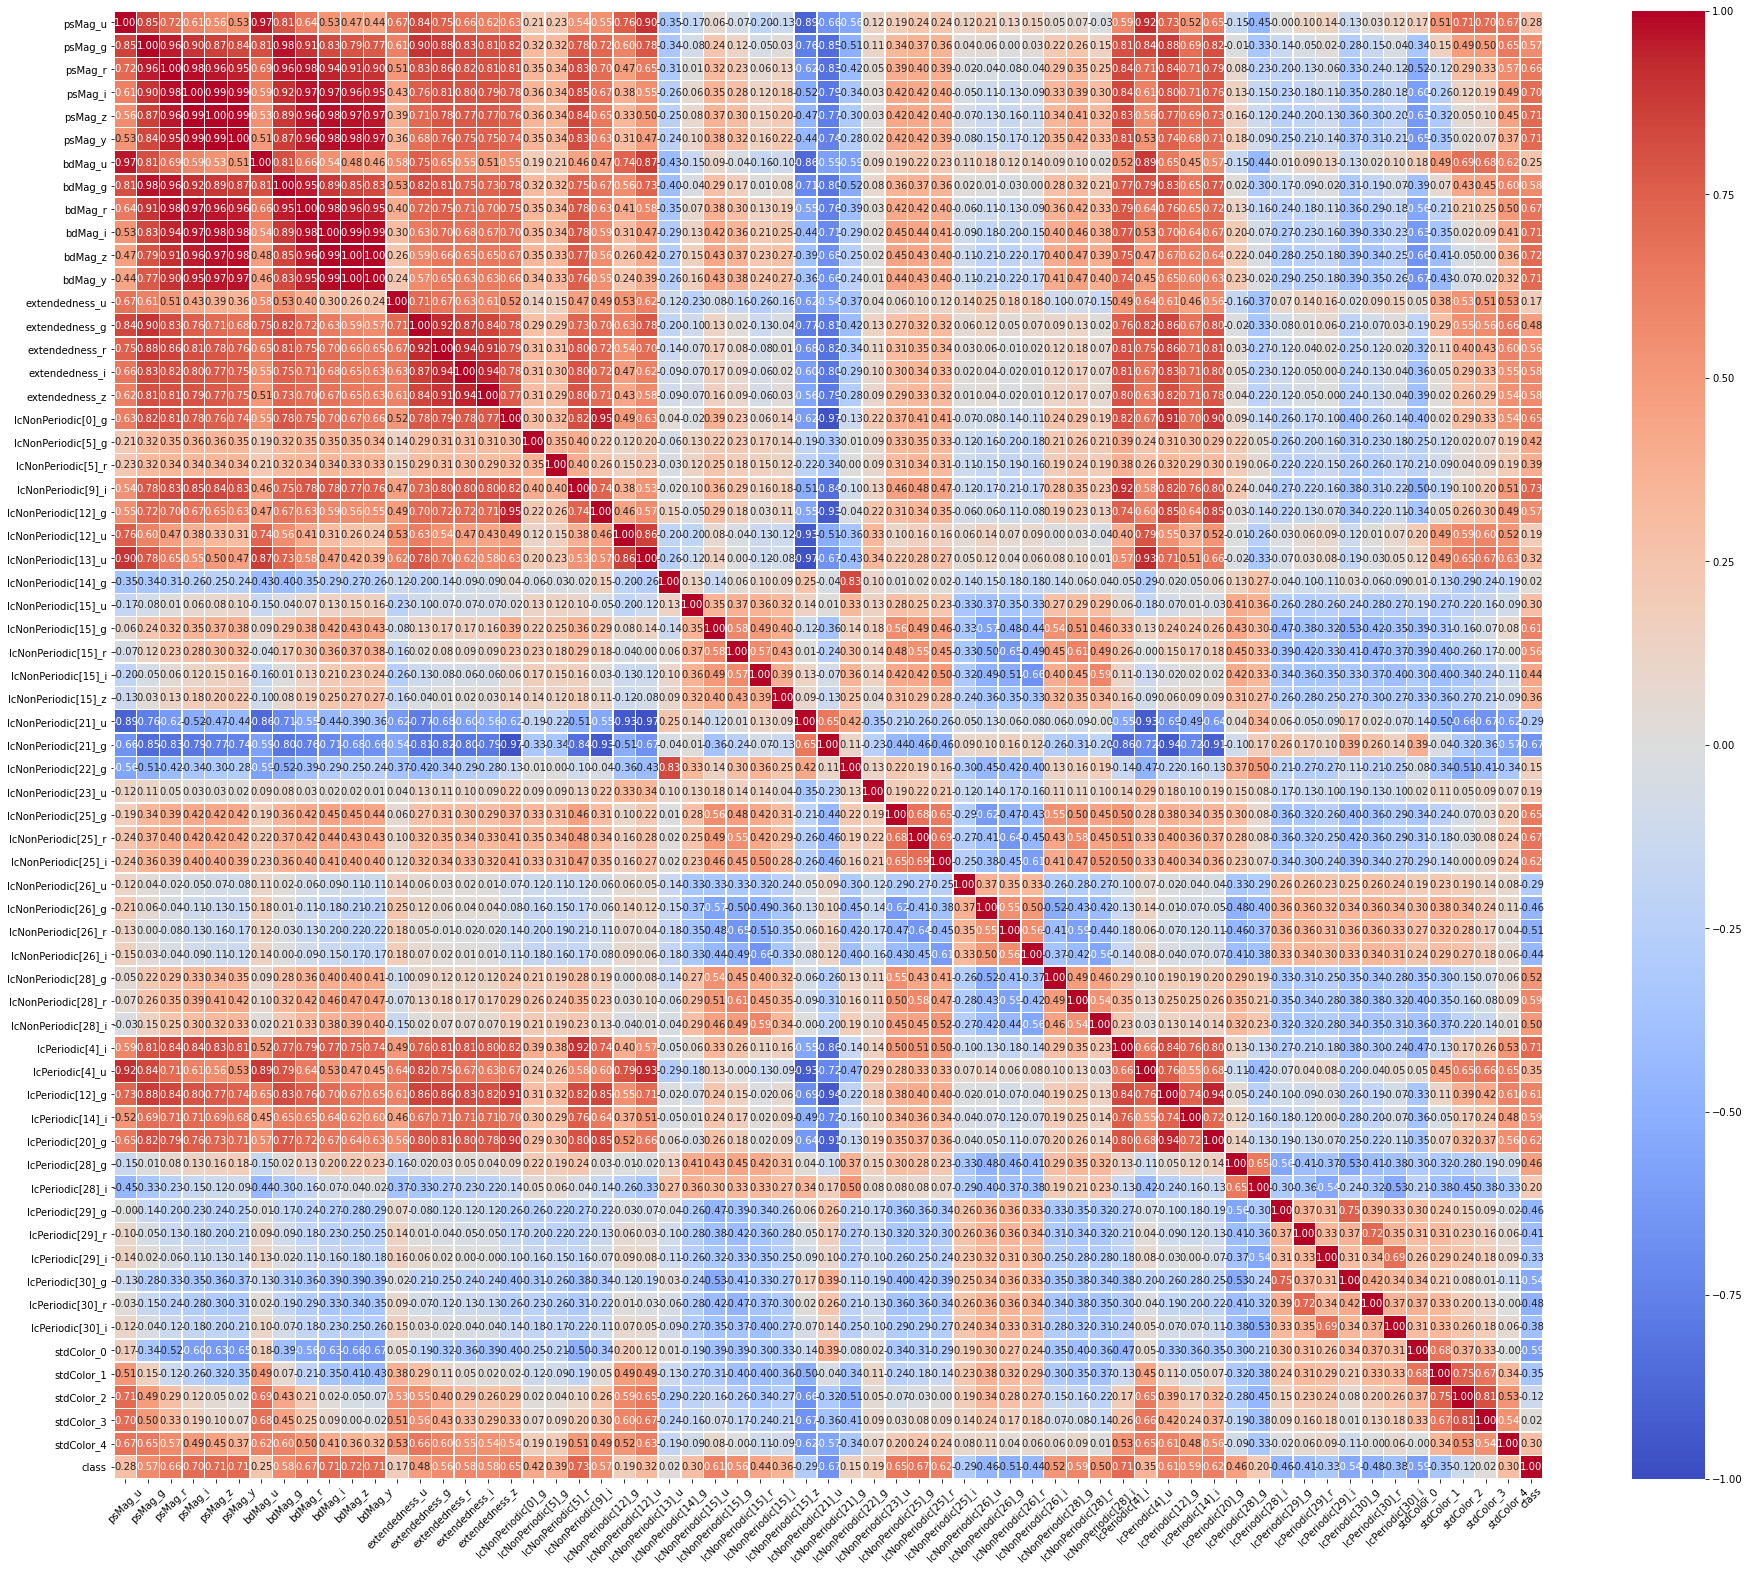

In [58]:
# Correlation matrix of the total sample of selected sources. Can be skipped when running the code.
corr = sample1_good.corr(method='spearman')
fig, ax = plt.subplots(figsize=(32,27))
sns.heatmap(data=corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidth=0.5)
plt.xticks(rotation=45)
plt.show()

array([[<AxesSubplot:title={'center':'psMag_u'}>,
        <AxesSubplot:title={'center':'psMag_g'}>,
        <AxesSubplot:title={'center':'psMag_r'}>,
        <AxesSubplot:title={'center':'psMag_i'}>,
        <AxesSubplot:title={'center':'psMag_z'}>,
        <AxesSubplot:title={'center':'psMag_y'}>,
        <AxesSubplot:title={'center':'bdMag_u'}>,
        <AxesSubplot:title={'center':'bdMag_g'}>],
       [<AxesSubplot:title={'center':'bdMag_r'}>,
        <AxesSubplot:title={'center':'bdMag_i'}>,
        <AxesSubplot:title={'center':'bdMag_z'}>,
        <AxesSubplot:title={'center':'bdMag_y'}>,
        <AxesSubplot:title={'center':'extendedness_u'}>,
        <AxesSubplot:title={'center':'extendedness_g'}>,
        <AxesSubplot:title={'center':'extendedness_r'}>,
        <AxesSubplot:title={'center':'extendedness_i'}>],
       [<AxesSubplot:title={'center':'extendedness_z'}>,
        <AxesSubplot:title={'center':'lcNonPeriodic[0]_g'}>,
        <AxesSubplot:title={'center':'lcNonPeriodic[

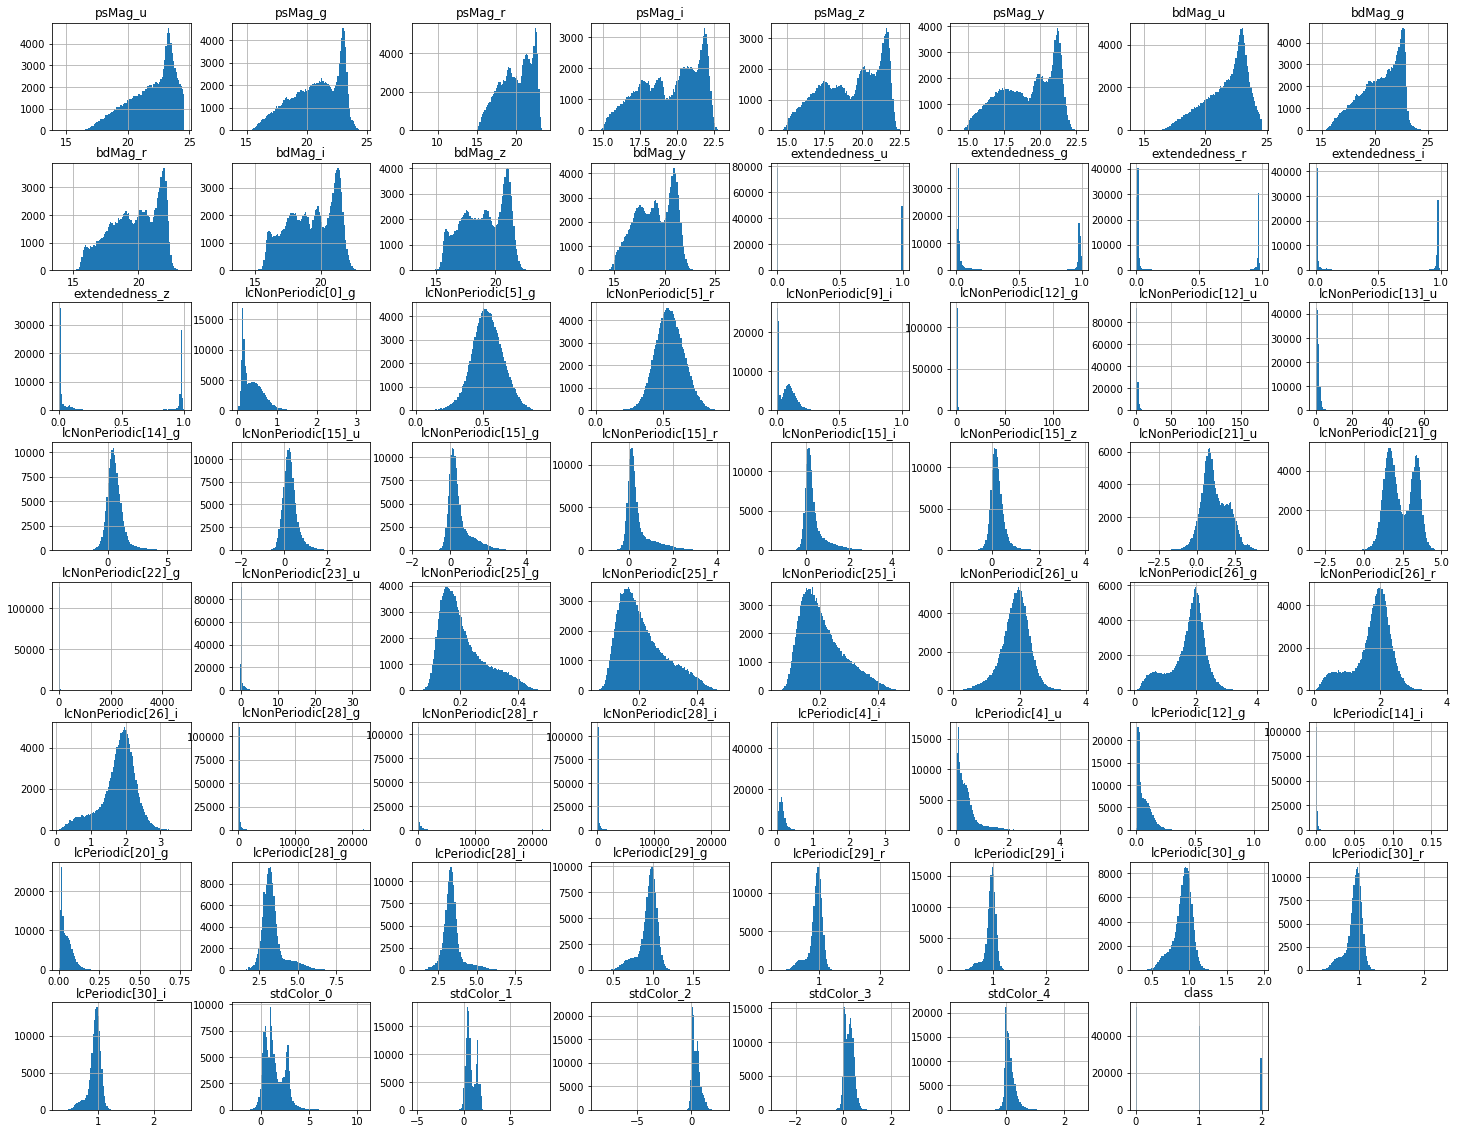

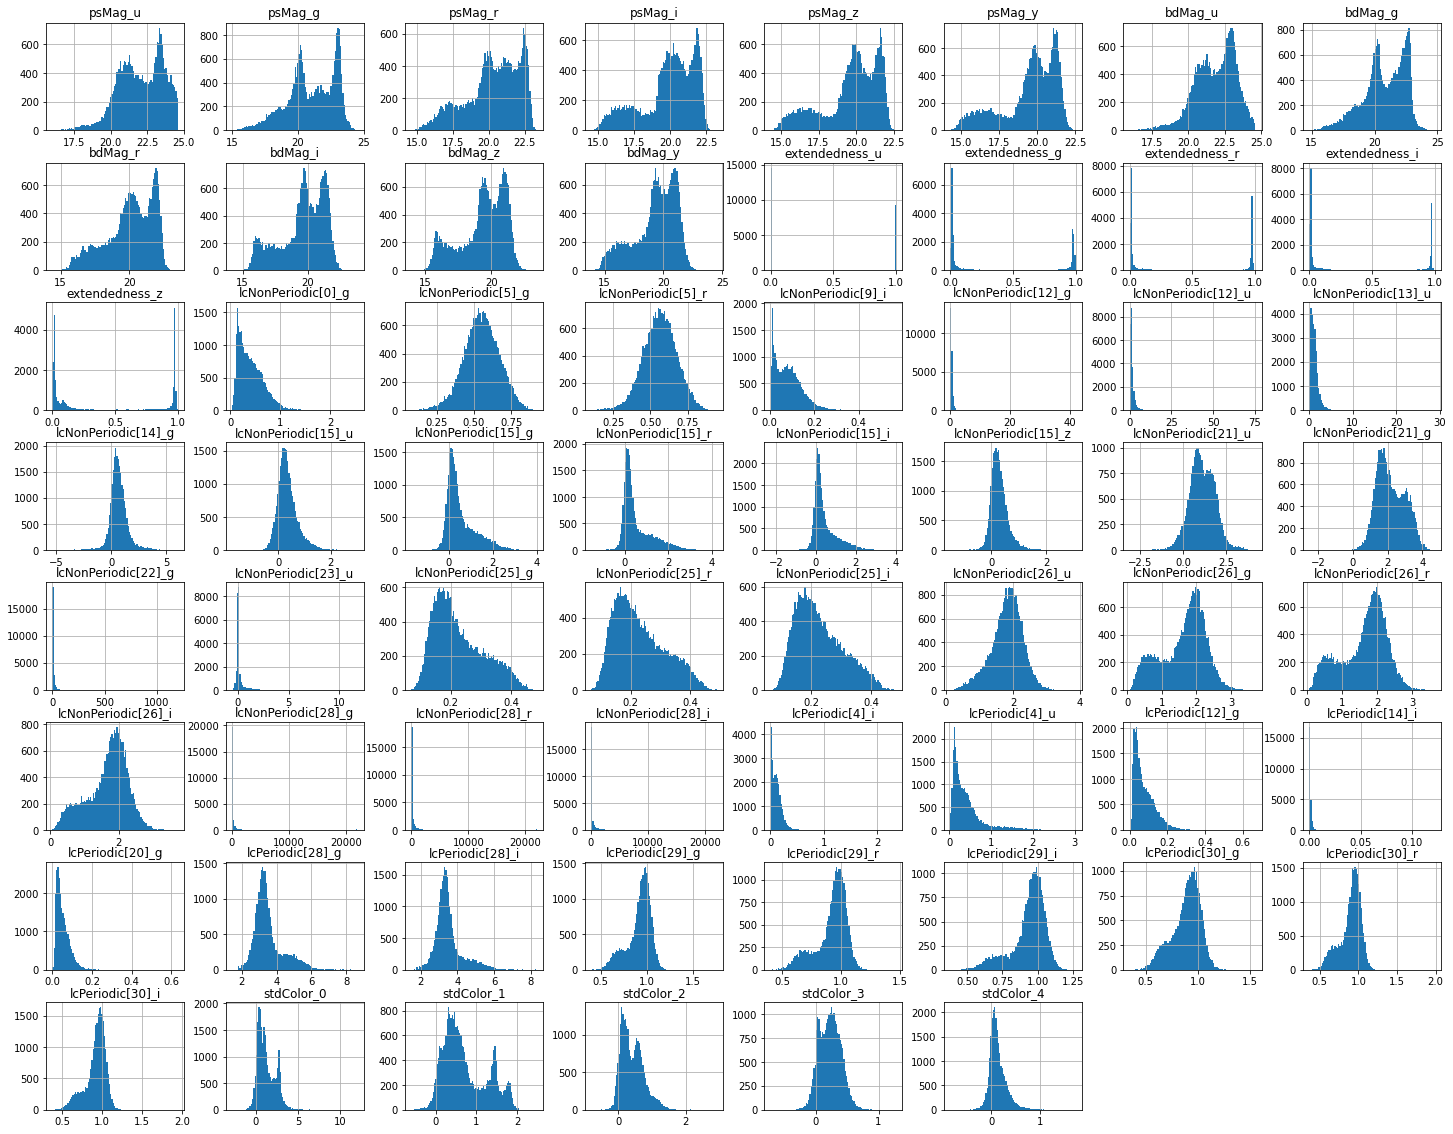

In [59]:
# Quick histograms of selected attributes for labeled and unlabeled data. Can be skipped.
sample1_good.hist(figsize = [25,20], bins=100)
sample1_good_unlab.hist(figsize = [25,20], bins=100)

Assigning X and y from the sample. After dropping NaN or missing values, 
we are left with a subsample consisting of 128072 objects, 
roughly 1/4 of the total number of objects in the Stripe82 Object Table (436990 objects with known labels).

In [8]:
X = sample1_good
# removing the class attribute from X data array
X = X.drop(['class'], axis=1)

# storing labels for later
y = sample1_good['class']
display(X.shape, y.shape)
display(X.describe())

(128072, 62)

(128072,)

,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,lcNonPeriodic[0]_g,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[9]_i,lcNonPeriodic[12]_g,lcNonPeriodic[12]_u,lcNonPeriodic[13]_u,lcNonPeriodic[14]_g,lcNonPeriodic[15]_u,lcNonPeriodic[15]_g,lcNonPeriodic[15]_r,lcNonPeriodic[15]_i,lcNonPeriodic[15]_z,lcNonPeriodic[21]_u,lcNonPeriodic[21]_g,lcNonPeriodic[22]_g,lcNonPeriodic[23]_u,lcNonPeriodic[25]_g,lcNonPeriodic[25]_r,lcNonPeriodic[25]_i,lcNonPeriodic[26]_u,lcNonPeriodic[26]_g,lcNonPeriodic[26]_r,lcNonPeriodic[26]_i,lcNonPeriodic[28]_g,lcNonPeriodic[28]_r,lcNonPeriodic[28]_i,lcPeriodic[4]_i,lcPeriodic[4]_u,lcPeriodic[12]_g,lcPeriodic[14]_i,lcPeriodic[20]_g,lcPeriodic[28]_g,lcPeriodic[28]_i,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4
count,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,1.280720e+05,128072.000000,1.280720e+05,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000,128072.000000
mean,21.911548,20.734600,19.966768,19.516869,19.280268,19.156759,21.719005,20.526552,19.720481,19.264627,19.025063,18.980647,0.384565,0.369165,0.351132,0.344133,0.380516,0.379932,0.534961,0.549180,0.073419,0.493459,1.698336,1.263126,0.613142,0.275088,0.434015,0.406890,0.344614,0.245887,1.179369,2.381630,7.858335,0.110413,0.208090,0.211610,0.209349,1.871531,1.753227,1.754892,1.778774,288.126963,241.921567,211.943298,1.024436e-01,0.393148,7.160801e-02,0.000967,0.048652,3.373748,3.410657,0.941165,0.947624,0.958866,0.914260,0.928043,0.942738,1.419629,0.767832,0.449898,0.236601,0.123509
std,1.845392,2.038847,2.021241,1.971828,1.952021,1.880470,1.721665,1.884545,1.860371,1.797789,1.794075,1.849457,0.486494,0.444247,0.447694,0.442383,0.443906,0.257209,0.113330,0.105548,0.063679,0.781850,2.738206,1.125079,0.704020,0.345267,0.578404,0.582253,0.497069,0.300085,0.879917,0.919628,28.360225,0.412135,0.077156,0.079245,0.074072,0.424707,0.570910,0.569373,0.518093,1906.758415,1476.713758,1275.307714,9.964118e-02,0.381254,5.881542e-02,0.001474,0.036555,0.749886,0.643569,0.115990,0.115764,0.106236,0.125766,0.123387,0.113295,1.069083,0.527406,0.369308,0.182543,0.177475
min,14.367890,14.298056,7.475252,14.649913,14.343253,14.194752,14.366130,14.427010,13.908188,13.694715,13.476674,13.334961,0.000000,0.000094,0.000097,0.000096,0.000102,0.027292,0.016464,0.012402,0.003347,0.026795,0.047840,0.052281,-4.107407,-2.131916,-1.716161,-1.420535,-1.363436,-1.497978,-4.016071,-3.093856,0.021080,-0.719257,0.053084,0.058077,0.053585,0.092938,0.051614,0.056655,0.067287,0.018316,0.018316,0.018316,3.000000e-08,0.013385,4.000000e-08,0.000000,0.000000,1.135493,1.151593,0.304325,0.314704,0.316983,0.289381,0.330331,0.297193,-2.361202,-4.951052,-8.632828,-2.787663,-1.722148
25%,20.617168,19.217322,18.399203,17.884996,17.637759,17.589959,20.573948,19.171829,18.287814,17.793523,17.539584,17.490436,0.000000,0.016267,0.011428,0.011446,0.015051,0.159096,0.460048,0.477344,0.014490,0.230223,0.713843,0.530847,0.186566,0.061436,0.065373,0.058691,0.051027,0.064026,0.587651,1.615939,1.712133,-0.007606,0.150403,0.151020,0.153121,1.633781,1.492928,1.505340,1.542

In [9]:
## Splitting data to train, test followed by standardization
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 1)

## standardization using StandardScaler applied to X_train (yields mean and sigma for X_train)
## and then standardizing X_train and X_test and X_unlab with mean and sigma obtained from X_train
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_unlab = scaler.transform(np.array(sample1_good_unlab))

display(X_train.shape, X_test.shape, X_unlab.shape)

(64036, 62)

(64036, 62)

(23847, 62)

## 3. Model definitions and training part

### Defining the autoencoder in Keras

Initially autoencoder was designed as a standard symmetric autoencoder for which the number of neurons
in the encoder decrease per layer, a block of a few deep layers followed by the symmetric decoder (with respect to the encoder).

After many trial and error attempts, the autoencoder composed of four layers with the same number of neurons equal to
input layer size. In total, we have only four dense layers for the autoencoder of which two dense layers are for the encoder.

In [10]:
n_input_layer = X.shape[1]
def Autoencoder(input_size):
    hidden_size = input_size
    code_size = input_size
    ### forming input vector and and hidden layers of autoencoder
    input_img = Input(shape=(input_size,))
    hidden_1 = Dense(hidden_size, activation='relu')(input_img)
    code = Dense(code_size, activation='relu')(hidden_1)
    #code = Dense(code_size, activation='relu')(code)
    hidden_2 = Dense(hidden_size, activation='relu')(code)
    output_img = Dense(input_size, activation='sigmoid')(hidden_2)    
    ### defining autoencoder, encoder and decoder parts
    encoder = Model(input_img, code)
    autoencoder = Model(input_img, output_img)
    
    #hidden_2 = Dense(code_size, activation='relu')
    #output_img = Dense(input_size, activation='sigmoid')(hidden_2)
    #decoder = encoder
    #decoder = Model(hidden_2, output_img)
    
    display(autoencoder.summary())
    display(encoder.summary())
    
    return autoencoder, encoder


autoencoder, encoder = Autoencoder(n_input_layer)

#display(encoder.output[0])
# we tried multiple deep layers, it is almost similar as with two.

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
dense (Dense)                (None, 62)                3906      
_________________________________________________________________
dense_1 (Dense)              (None, 62)                3906      
_________________________________________________________________
dense_2 (Dense)              (None, 62)                3906      
_________________________________________________________________
dense_3 (Dense)              (None, 62)                3906      
Total params: 15,624
Trainable params: 15,624
Non-trainable params: 0
_________________________________________________________________


None

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
dense (Dense)                (None, 62)                3906      
_________________________________________________________________
dense_1 (Dense)              (None, 62)                3906      
Total params: 7,812
Trainable params: 7,812
Non-trainable params: 0
_________________________________________________________________


None

Compiling the autoencoder. We used mean squared error for loss and stochastic gradient descent with momentum as optimizer
We pretrain the model on X_train i.e. the model attempts to learn itself by minimizing the mean squarred error.

In [11]:
num_epochs = 40
autoencoder.compile(
                    optimizer='adam', loss='mse'
                    #optimizer=SGD(0.01, 0.9), loss='mse'
                    #loss='mae',
                    )
history = autoencoder.fit(X_train, X_train, epochs=num_epochs)

Epoch 1/40
2002/2002 [==============================] - 3s 1ms/step - loss: 0.6505
Epoch 2/40
2002/2002 [==============================] - 2s 1ms/step - loss: 0.6089
Epoch 3/40
2002/2002 [==============================] - 2s 1ms/step - loss: 0.6037
Epoch 4/40
2002/2002 [==============================] - 3s 1ms/step - loss: 0.6010
Epoch 5/40
2002/2002 [==============================] - 3s 1ms/step - loss: 0.5993
Epoch 6/40
2002/2002 [==============================] - 3s 1ms/step - loss: 0.5980
Epoch 7/40
2002/2002 [==============================] - 3s 2ms/step - loss: 0.5971
Epoch 8/40
2002/2002 [==============================] - 3s 2ms/step - loss: 0.5964
Epoch 9/40
2002/2002 [==============================] - 3s 2ms/step - loss: 0.5957
Epoch 10/40
2002/2002 [==============================] - 3s 2ms/step - loss: 0.5953
Epoch 11/40
2002/2002 [==============================] - 3s 1ms/step - loss: 0.5949
Epoch 12/40
2002/2002 [==============================] - 2s 1ms/step - loss: 0.5948
E

With the autoencoder trained, we create a new model for which a clustering layer is added to the encoder output. Initial
model weights are already saved after autoencoder training. 
Our goal is to explore how would labels Star, Gal and Qso correspond to the three clusters found by unsupervised learning.

In [14]:
n_clusters = 3

# appending clustering layer to the encoder
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
# displaying deep embedding clustering model description
display(model.summary())
# plotting the clustering model architecture
tf.keras.utils.plot_model(model, to_file='DEC.png', show_shapes=True)
#display(model.layers[1].get_weights()[0])

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
dense (Dense)                (None, 62)                3906      
_________________________________________________________________
dense_1 (Dense)              (None, 62)                3906      
_________________________________________________________________
clustering (ClusteringLayer) (None, 3)                 186       
Total params: 7,998
Trainable params: 7,998
Non-trainable params: 0
_________________________________________________________________


None

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


Initial weights for the clustering layer are assigned using the K nearest neighbours. 10-30 nearest neighbours work good
Very important, DEC model is trained by minimizing Kullback–Leibler divergence (relative entropy)

In [15]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld'
              #optimizer='adam', loss='kld',
             )
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(X_train))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
#display(model.layers[-1].get_weights()[0])

### Experimental facts after many trial and error attempts for the DEC model with 2 dense layers of 62 fully connected neurons and a clustering layer with 3 clusters.

Pretrained autoencoder up to 50 epochs with loss 'mse' works better than 'mae'. Iteratively train model for
around 400~800 iterations. K-nearest neighbours with 20 +- 5 is just fine. Can reach around 97% accuracy when
labels are assigned later to see if there is indeed any clustering towards our labels. On average, it performs 
around 94-96% accuracy. 
Largely unstable per initial conditions of the autoencoder and k-means centroids.
Train/test split is 50:50. We do not care much about the loss as compared to the adjusted rand score and normalized mutual
information. Adapted from original work by Junyuan Xie et al. (2015) https://arxiv.org/pdf/1511.06335.pdf
Training with a large number of iterations leads to gradually worse performance when labels are assigned. 
The best results are achieved when ari reaches local minimum or maximum.
Testing larger/different network architectures as well as concatenating this model with images
could hopefuly bring improvements as it was the case for supervised learning we did. Adding more dense layer to this model
leads to no improvement.

In [16]:
loss = 0
index = 0
maxiter = 805
update_interval = 50
index_array = np.arange(X_train.shape[0])
tol = 1e-4 # tolerance threshold to stop training
batch_size = 1024*2

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(X_train, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y_train is not None:
            acc = np.round(accuracy_score(y_train, y_pred), 5)
            nmi = np.round(nmi_f(y_train, y_pred), 5)
            ari = np.round(ari_f(y_train, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)
            #print('Iter %d: nmi = %.5f, ari = %.5f' % (ite, nmi, ari), ' ; loss=', loss)
        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, X_train.shape[0])]
    loss = model.train_on_batch(x=X_train[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= X_train.shape[0] else 0

print("Iter_prev: {}".format(ite))

Iter 0: acc = 0.43590, nmi = 0.66076, ari = 0.70265  ; loss= 0
Iter 50: acc = 0.42927, nmi = 0.68882, ari = 0.73475  ; loss= 0.05785
Iter 100: acc = 0.42417, nmi = 0.71286, ari = 0.76112  ; loss= 0.0716
Iter 150: acc = 0.42175, nmi = 0.73578, ari = 0.78650  ; loss= 0.07588
Iter 200: acc = 0.42023, nmi = 0.75478, ari = 0.80790  ; loss= 0.08123
Iter 250: acc = 0.42001, nmi = 0.77022, ari = 0.82546  ; loss= 0.08528
Iter 300: acc = 0.42067, nmi = 0.78328, ari = 0.84055  ; loss= 0.08949
Iter 350: acc = 0.42195, nmi = 0.79467, ari = 0.85395  ; loss= 0.09221
Iter 400: acc = 0.42331, nmi = 0.80403, ari = 0.86491  ; loss= 0.09422
Iter 450: acc = 0.42412, nmi = 0.81241, ari = 0.87383  ; loss= 0.09616
Iter 500: acc = 0.42529, nmi = 0.81825, ari = 0.88070  ; loss= 0.09749
Iter 550: acc = 0.42662, nmi = 0.82349, ari = 0.88670  ; loss= 0.09789
Iter 600: acc = 0.42753, nmi = 0.82821, ari = 0.89156  ; loss= 0.10183
Iter 650: acc = 0.42831, nmi = 0.83107, ari = 0.89464  ; loss= 0.10361
Iter 700: acc = 

Considering this is an unsupervised learning algorithm, the model it is able to find clusters in the data but it can not assign 
correct labels since it has no previous knowledge. To mitigate this, we use labels already available in the data and match 
them with each object in the clusters which results in correct cluster labeling.

Since the model has no information on the labels we investigate whether there is any clustering towards class labels. Clusters determined this way are indeed in a good agreement with class labels although, the model has no information whether clusters labeled [0, 1, 2] are correctly assigned i.e. that 0 belongs to Star, 1 to Gal and 2 to Qso. This is updated in the next cell after the one below.

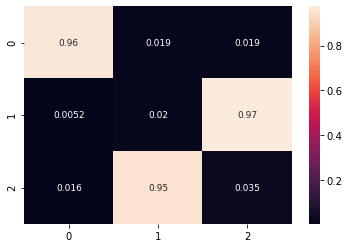

'f1 score: [0.97451099 0.02484574 0.0260905 ]'

'accuracy: 0.43044537447685677'

In [17]:
#Evaluating the model and plotting confusion matrix.
q = model.predict(X_train, verbose=0)

y_pred = q.argmax(1)
acc = accuracy_score(y_train, y_pred)
cf = confusion_matrix(y_train, y_pred)
cf_n = np.zeros(cf.shape)

for i in range(cf.shape[0]):
    row_normalized = np.divide(cf[i, :], np.sum(cf[i, :]))
    cf_n[i, :] = row_normalized

sns.heatmap(cf_n, annot=True, annot_kws={"size": 9}) # font size
plt.show()
display("f1 score: {}".format(f1_score(y_train, y_pred, average=None)))
display("accuracy: {}".format(acc))

### Correct assignement of labels: 0:Star, 1:Gal, 2:Qso
A correct label assignment is done by inspecting the confusion matrix. We compare the cluster label with the class label
from the data and match them. Class labels [0, 1, 2] are assigned to the cluster labels e.g. [1, 0, 2] (or any other
permutation of the list). Once the assignment is done, we evaluate the accuracy, 
and plot the absolute and normalized confusion matrix

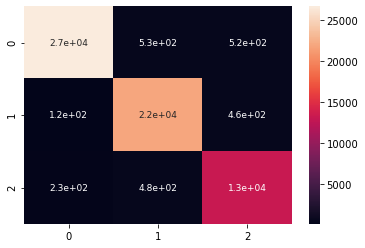

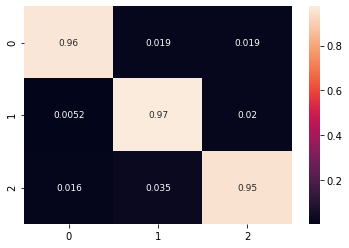

'accuracy score of:  0.963645449434693'

'total number of class, number of missclasified objects (array([27677, 22480, 13879]), array([1048,  573,  707]))'

'f1 score is:  [0.97451099 0.96515111 0.94001784]'

'Saving DEC model to + ./NNcheckpoints/DEC.hp'

INFO:tensorflow:Assets written to: ./NNcheckpoints/DEC.hp/assets


In [21]:
q = model.predict(X_train, verbose=0)

y_pred = q.argmax(1)
cf = confusion_matrix(y_train, y_pred)
cf_n = np.zeros(cf.shape)
original_labels = np.array([0, 1, 2])
y_pred_copy = y_pred.copy()

# label assignment
unsupervised_labels = np.array([np.argmax(cf[0, :]), np.argmax(cf[1, :]), np.argmax(cf[2, :])])
for i, j in zip(original_labels, unsupervised_labels):
    y_pred_copy[y_pred == j] = i
    #display(i, j)
y_pred_corr = y_pred_copy

# new confusion matrix with correct label assignment
cf = confusion_matrix(y_train, y_pred_corr)
cf_n = np.zeros(cf.shape)
labels_misscla = np.array(np.sum(cf, axis=1) - np.diag(cf))
for i in range(cf.shape[0]):
    row_normalized = np.divide(cf[i, :], np.sum(cf[i, :]))
    cf_n[i, :] = row_normalized
    
acc = accuracy_score(y_train, y_pred_corr)    
sns.heatmap(cf, annot=True, annot_kws={"size": 9}) # font size
plt.show()
sns.heatmap(cf_n, annot=True, annot_kws={"size": 9}) # font size
plt.show()
display(f"accuracy score of:  {accuracy_score(y_train, y_pred_corr)}")
display(f"total number of class, number of missclasified objects {np.sum(cf, axis=1),labels_misscla.T}")
display(f"f1 score is:  {f1_score(y_train, y_pred_corr, average=None)}")

modelDEC_save_name = './NNcheckpoints/DEC.hp'
display("Saving DEC model to + " + modelDEC_save_name)
model.save(modelDEC_save_name)

## 4. Loading the pretrained model
Training can be skipped by loading one of the models with prefix "DEC_acc". After running this cell, correct label assignment and evaluation can be done by running the previous cell. However, all the pre-processing following the steps we did is required

In [9]:
#model = tf.keras.models.load_model(modelDEC_save_name) # loading the latest trained model
model = tf.keras.models.load_model('./NNcheckpoints/DEC.hp')
display(model.summary())

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
dense (Dense)                (None, 62)                3906      
_________________________________________________________________
dense_1 (Dense)              (None, 62)                3906      
_________________________________________________________________
clustering (ClusteringLayer) (None, 3)                 186       
Total params: 7,998
Trainable params: 7,998
Non-trainable params: 0
_________________________________________________________________


None

## 5. Conclusion

This notebook attempts to bring us closer towards a data driven unsupervised clustering model that could identify any detected object as either a star or a galaxy or a qso. We show that the accuracy of 97% could be achieved with DEC due to the inclusion of carefuly selected periodicity and nonperiodicity parameters. Although this model performs with worse by ~1% when compared with supervised models, this is a promising result for developing more accurate unsupervised model in similar fashion since we used the simplest two-layer encoder.

An ongoing research is in progress: training autoencoder and clustering model jointly. Also building an Improved Deep Embedded Clustering with Local Structure Preservation ([Guo et al. 2017](https://www.ijcai.org/proceedings/2017/0243.pdf)).
Further improvement will be investigated by including the object images for training more complex unsupervised DEC model.

---
### => WY: Test on Blinded Dataset <=

#### 1. Read the blindeded dataset & Preprocess
- Read the full blinded dataset & clean up
- Re-format and get ready for test

In [10]:
# read whole dataset
blinded_df_og = pd.read_parquet(os.path.join(data_dir, 'ObjectTable_Blinded.parquet'))

# select those having LCs & and computed features
lc_cols = [col for col in blinded_df_og.columns if 'Periodic' in col]
blinded_df = blinded_df_og.dropna(subset=lc_cols, how='all').copy()

# select only the columns specified above (see attr_list) & drop nan
blinded_df = blinded_df[attr_list].dropna()

# replace class str with int
blinded_df = blinded_df.replace({'class': {'Star': 0, 'Gal': 1, 'Qso': 2, 'Agn': 2, 'highZQso': 2}})

# print number of objects in the final blinded test set
print(f'Total Number of objects in the final blinded test set: {len(blinded_df)}')
print('Counts for each class: ')
blinded_df['class'].value_counts()

Total Number of objects in the final blinded test set: 14891
Counts for each class: 


1    8406
2    5222
0    1263
Name: class, dtype: int64

In [11]:
# re-format
X_b = blinded_df.drop(['class'], axis=1)
y_b = blinded_df['class']

# re-scale
# scaler = preprocessing.StandardScaler()
# scaler.fit(X_b)
X_b = scaler.transform(X_b)

### 2. Load Pre-trained Model

In [12]:
model = tf.keras.models.load_model('./NNcheckpoints/DEC.hp')
display(model.summary())

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
dense (Dense)                (None, 62)                3906      
_________________________________________________________________
dense_1 (Dense)              (None, 62)                3906      
_________________________________________________________________
clustering (ClusteringLayer) (None, 3)                 186       
Total params: 7,998
Trainable params: 7,998
Non-trainable params: 0
_________________________________________________________________


None

#### 3. Send through the DEC model

In [13]:
# predict
q_b = model.predict(X_b, verbose=0)
y_b_pred = q_b.argmax(1)

# initial confusion matrix (before assign correct labels)
cf = confusion_matrix(y_b, y_b_pred)
cf_n = np.zeros(cf.shape)

# label assignment
original_labels = np.array([0, 1, 2])
y_b_pred_copy = y_b_pred.copy()
unsupervised_labels = np.array([np.argmax(cf[0, :]), np.argmax(cf[1, :]), np.argmax(cf[2, :])])
for i, j in zip(original_labels, unsupervised_labels):
    y_b_pred_copy[y_b_pred == j] = i
y_b_pred_corr = y_b_pred_copy

'accuracy score of:  0.9489624605466389'

'total number of class, number of missclasified objects (array([1263, 8406, 5222]), array([ 334, 8221, 5064]))'

'f1 score is:  [0.8167033  0.96749793 0.94775626]'

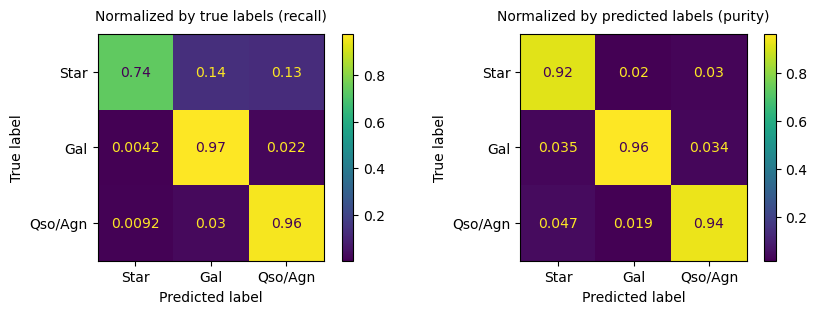

In [14]:
# make plots
fig, axes = plt.subplots(1, 2, dpi=100, figsize=(10, 3))
str_labels = ['Star', 'Gal', 'Qso/Agn']
cf_n_t = confusion_matrix(y_b, y_b_pred_corr, normalize='true')
cf_n_p = confusion_matrix(y_b, y_b_pred_corr, normalize='pred')
ConfusionMatrixDisplay(cf_n_t, display_labels=str_labels).plot(ax=axes[0])
ConfusionMatrixDisplay(cf_n_p, display_labels=str_labels).plot(ax=axes[1])
axes[0].set_title('Normalized by true labels (recall)', pad=10, fontsize=10)
axes[1].set_title('Normalized by predicted labels (purity)', pad=10, fontsize=10)

acc = accuracy_score(y_b, y_b_pred_corr)
labels_misscla = np.array(np.sum(cf, axis=1) - np.diag(cf))
display(f"accuracy score of:  {acc}")
display(f"total number of class, number of missclasified objects {np.sum(cf, axis=1), labels_misscla.T}")
display(f"f1 score is:  {f1_score(y_b, y_b_pred_corr, average=None)}")